# Support Vector Machine Predictive Model for EDTA QC Evaluation: Part 1 – Model Building

We will build a **Support Vector Machine** (SVM) classifier using **scikit-learn**. Two datasets (training and testing) containing experimental data from healthy donors (described in the current manuscript: https://neco.cz..........................) are used for model development.


Contents:
- **Data Preprocessing Before Loading**

- **Module Imports**

- **Importing and Preprocessing Training and Testing data, and Building the Final SVM**
    - Importing training and testing data
    - Splitting the data into independent and dependent variables
    - Scaling the data  
    - Scree plot and PCA transformation  
    - Selecting optimal hyperparameters for SVM with RBF kernel
    - Building the best SVM with RBF kernel and its metrics
    - Selecting optimal hyperparameters for SVM with polynomial kernel
    - Building the best SVM with polynomial kernel and its metrics
    - Prediction results using both models
    - Selection of the final SVM model
    - Forming pipeline from scaler, PCA, and best polynomial SVM 
    - Visualizing the decision boundary for the polynomial SVM using the two principal components  
    - Summarizing training and testing data

----
----

#### **Data Preprocessing Before Loading**

The first step is to clean the data.
- Any samples with missing data were excluded. 
- Data were normalized using three reference genes: GAPDH, GUSB, and PPIB (sequences of optimized primers can be found at https://pubmed.ncbi.nlm.nih.gov/25369468/).
- Data were checked for outliers, which were excluded (no outliers are allowed in the training data). 
- In Genex Enterprise (MultiD), SOM analysis identified two classes in the training set.

----
----

#### **Module Import**

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from IPython.display import Markdown, display
from sklearn.model_selection import cross_val_score
from pathlib import Path

In [2]:
# ── Setup paths relative to project root ──
cwd = Path().cwd()
ROOT = cwd
while not (ROOT / "README.md").exists():
    ROOT = ROOT.parent 

DATA_DIR   = ROOT / "data"
MODELS_DIR = ROOT / "models"

TRAIN_DATA_PATH   = DATA_DIR / "train_data.csv"
TEST_DATA_PATH    = DATA_DIR / "test_data.csv"
EXAMPLE_DATA_PATH = DATA_DIR / "example_new_samples.csv"

PIPELINE_PATH = MODELS_DIR / "final_pipeline_prob.joblib"
# ── End setup ──

# ── Notebook outputs folder ──
NB_OUTPUT = ROOT / "notebooks" / "outputs_from_notebooks"
NB_OUTPUT.mkdir(parents=True, exist_ok=True)
# ── End notebook outputs setup ──

----
----

#### **Importing and Preprocessing Training and Testing data, and Building the Final SVM**

In this section, we will use the training data and new test data measured independently on a different day. We will then select the final SVM model.

#### Task 1: Importing training and testing data

In [3]:
train_df = pd.read_csv(TRAIN_DATA_PATH, index_col=0)
test_df = pd.read_csv(TEST_DATA_PATH, index_col=0) 

In [4]:
train_df. head()

,BTG3,CD69,CXCR1,CXCR2,FCGR3A,JUN,STEAP4,groups
sample,,,,,,,,
1_EDTA pre T0,6.136667,8.406667,-0.793333,-1.183333,-3.463333,5.316667,0.676667,1
2_EDTA pre T0,6.143333,8.053333,-1.156667,-0.976667,-3.066667,3.853333,0.263333,1
3_EDTA preT0,6.546667,7.976667,-1.253333,-1.093333,-2.613333,5.126667,-0.143333,1
4_EDTA pre T0,5.816667,8.466667,-0.433333,-0.653333,-2.523333,3.796667,0.736667,1
5_EDTA pre T0,6.366667,7.366667,-1.223333,-1.193333,-3.203333,4.576667,-0.113333,1


- Group 1: OK samples
- Group 0: samples with altered gene expression  

----

#### Task 2: Splitting the data into independent and dependent variables

In [5]:
X_train = train_df.drop('groups', axis=1)
y_train = train_df['groups']
X_test = test_df.drop('groups', axis=1)
y_test = test_df['groups']

In [6]:
X_test.head()

,BTG3,CD69,CXCR1,CXCR2,FCGR3A,JUN,STEAP4
sample,,,,,,,
EDTA 8759-0,4.800000,4.000000,-3.200000,-1.400000,-4.400000,3.900000,-1.400000
EDTA 8759-24,2.433333,-0.066667,-0.366667,0.433333,-2.966667,-2.166667,0.033333
EDTA 8760-0,5.166667,4.266667,-3.033333,-1.233333,-4.533333,5.066667,-0.433333
EDTA 8760-24,2.600000,0.000000,-0.400000,0.600000,-3.200000,-2.100000,1.200000
EDTA 8761-0,4.900000,3.800000,-3.500000,-1.500000,-4.800000,4.200000,-1.400000


In [7]:
print(y_test)

sample
EDTA 8759-0     1
EDTA 8759-24    0
EDTA 8760-0     1
EDTA 8760-24    0
EDTA 8761-0     1
EDTA 8762-0     1
EDTA 8762-24    0
EDTA 8764-0     1
EDTA T0 1       1
EDTA T0 2       1
EDTA T0 3       1
EDTA T0 6       1
EDTA T0 7       1
EDTA T24 1      0
EDTA T24 2      0
EDTA T24 3      0
EDTA T24 4      0
EDTA T24 5      0
EDTA T24 7      0
EDTA T6 1       1
EDTA T6 2       1
EDTA T6 3       1
EDTA T6 4       1
Name: groups, dtype: int64


In [8]:
print("🔹 Number of samples in the training set:")
print(f"Class 0: {np.sum(y_train == 0)}")
print(f"Class 1: {np.sum(y_train == 1)}")

print("\n🔹 Number of samples in the testing set:")
print(f"Class 0: {np.sum(y_test == 0)}")
print(f"Class 1: {np.sum(y_test == 1)}")

🔹 Number of samples in the training set:
Class 0: 139
Class 1: 81

🔹 Number of samples in the testing set:
Class 0: 9
Class 1: 14


----

#### Task 3: Scaling the data

In [9]:
# Initialization of StandardScaler
scaler = StandardScaler()

# Fit and transform training data only
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)


----

#### Task 4: Scree plot and PCA transformation

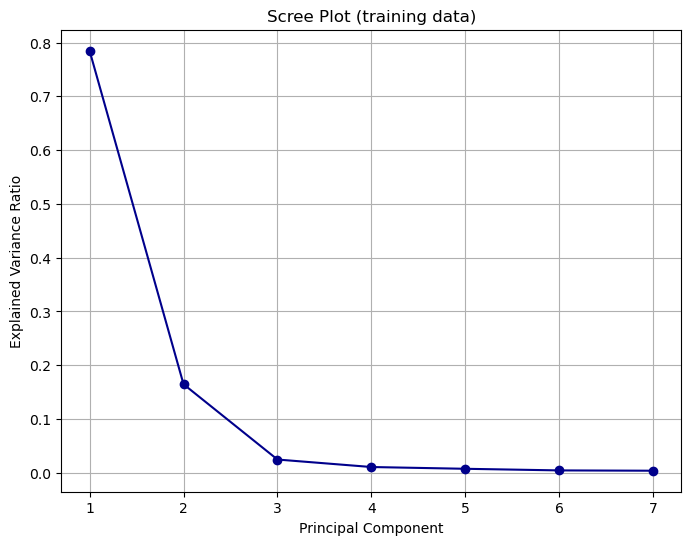

In [10]:
# Fit PCA on all components
pca_full = PCA().fit(X_train_scaled)  

# Scree plot of explained variance ratio
plt.figure(figsize=(8,6))
plt.plot(
    range(1, len(pca_full.explained_variance_ratio_) + 1), 
    pca_full.explained_variance_ratio_, 
    'o-', color='darkblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (training data)')
plt.xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

In [11]:

# I chose only two principal components because they suffice for modeling
pca2 = PCA(n_components=2)
X_train_pca2 = pca2.fit_transform(X_train_scaled)
X_test_pca2 = pca2.transform(X_test_scaled)

print(
    f"✅ Training and test sets have been scaled and PCA-transformed: "
    f"{X_train_pca2.shape} train, {X_test_pca2.shape} test.")

✅ Training and test sets have been scaled and PCA-transformed: (220, 2) train, (23, 2) test.


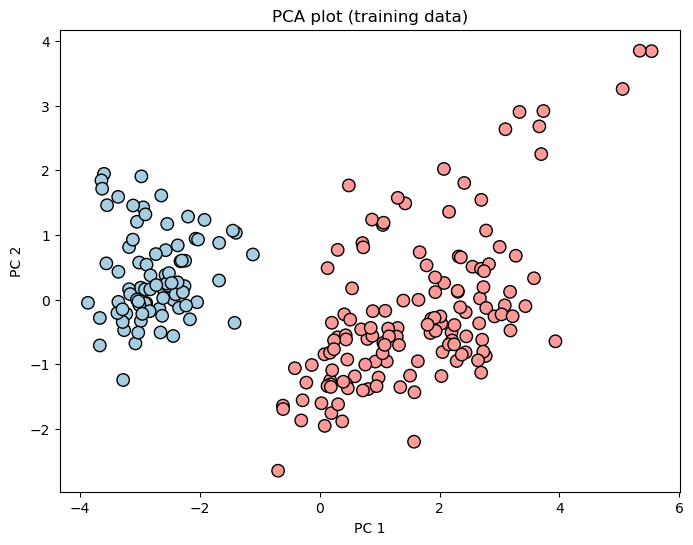

In [12]:
plt.figure(figsize=(8,6))

# Define color palettes
cmap_train = mcolors.ListedColormap(['#fb9a99', '#a6cee3']) # Light colors for train data
cmap_test = mcolors.ListedColormap(['#e31a1c', '#1f78b4'])  # Dark colors for test data

# Scatter plot: training data
scatter_train = plt.scatter(X_train_pca2[:, 0], X_train_pca2[:, 1],
                            c=y_train, cmap=cmap_train, edgecolors='k', s=80, label='Trénovací')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA plot (training data)')
plt.show()

----

#### Task 5: Selecting optimal hyperparameters for SVM with RBF kernel

The data are formatted correctly for training the SVM. Now we need to optimize the hyperparameters.

In [13]:
# Define StratifiedKFold for inner CV
cv_rbf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter grid for RBF kernel
param_grid_rbf = {
    'C':    [0.1, 1, 10, 100],
    'gamma':['scale', 'auto', 0.01, 0.1, 1]
}

# Instantiate SVC with RBF kernel (no .fit() yet)
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)

# GridSearchCV for RBF (refit=True ensures best_estimator_ is fitted on all training data)
grid_search_rbf = GridSearchCV(
    estimator=svm_rbf,
    param_grid=param_grid_rbf,
    cv=cv_rbf,
    scoring='f1',
    n_jobs=-1,
    refit=True
)
grid_search_rbf.fit(X_train_pca2, y_train)

print("🔹 Best parameters (RBF):", grid_search_rbf.best_params_)
print("🔹 Inner CV best F1 (average across folds) for RBF:", f"{grid_search_rbf.best_score_:.3f}")


🔹 Best parameters (RBF): {'C': 0.1, 'gamma': 'scale'}
🔹 Inner CV best F1 (average across folds) for RBF: 1.000


----

#### Task 6: Building the best SVM with RBF kernel and its metrics

In [14]:
# Extract the best RBF model (fitted on all training data)
best_svm_rbf = grid_search_rbf.best_estimator_

# Predict on the test set using the refitted RBF model
y_test_pred_rbf = best_svm_rbf.predict(X_test_pca2)
print("\n🔹 Classification report for RBF model (test set):")
print(classification_report(y_test, y_test_pred_rbf, target_names=["Class 0", "Class 1"]))



🔹 Classification report for RBF model (test set):
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         9
     Class 1       1.00      1.00      1.00        14

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



🔹Confusion matrix:


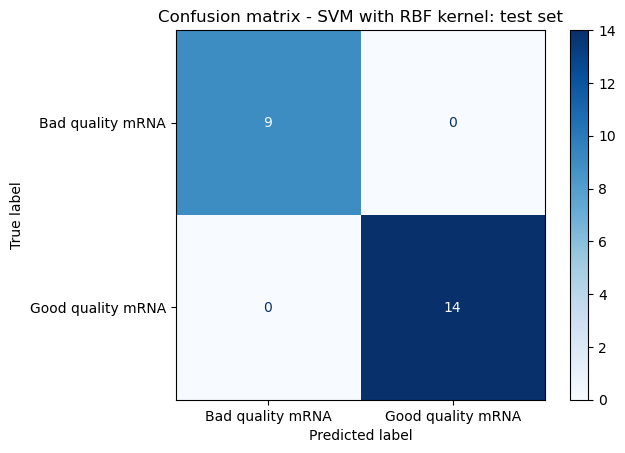

In [15]:
# Confusion matrix using test data
print("🔹Confusion matrix:")
ConfusionMatrixDisplay.from_predictions(
    y_test,  # Actual values
    y_test_pred_rbf,  # Predicted values
    display_labels=["Bad quality mRNA", "Good quality mRNA"],  
    cmap='Blues'  # Color map
)
plt.title('Confusion matrix - SVM with RBF kernel: test set')
plt.show()

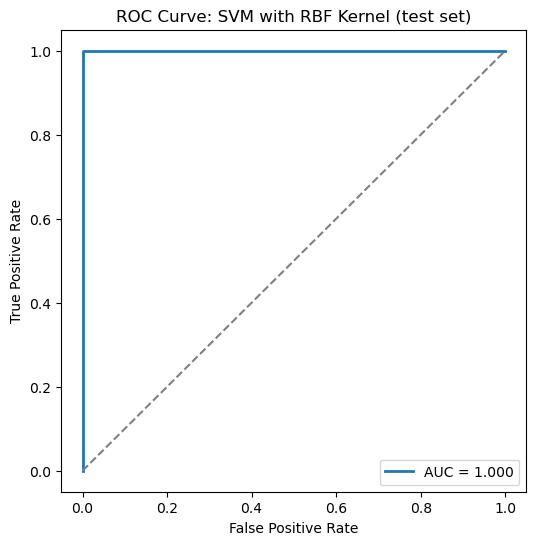

In [16]:
# Compute and plot ROC curve and AUC for RBF model (test set)
y_test_scores_rbf = best_svm_rbf.decision_function(X_test_pca2)
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_test_scores_rbf)
roc_auc_rbf = auc(fpr_rbf, tpr_rbf)

plt.figure(figsize=(6, 6))
plt.plot(fpr_rbf, tpr_rbf, lw=2, label=f'AUC = {roc_auc_rbf:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SVM with RBF Kernel (test set)')
plt.legend(loc='lower right')
plt.show()

In [17]:

n_per_class_rbf = best_svm_rbf.n_support_        
total_sv_rbf   = n_per_class_rbf.sum() 
ratio_rbf = total_sv_rbf / len(X_train_pca2)            

In [18]:
text = f"""
### SVM model characteristics (RBF kernel)

- **Kernel:** `RBF` (degree={best_svm_rbf.degree}, coef0={best_svm_rbf.coef0})  
- **Support vectors (per class):** {n_per_class_rbf.tolist()}  
- **Total support vectors:** {total_sv_rbf} ({ratio_rbf:.1%} of training data)  
- **AUC (test set):** {roc_auc_rbf:.2f}  
"""

display(Markdown(text))


### SVM model characteristics (RBF kernel)

- **Kernel:** `RBF` (degree=3, coef0=0.0)  
- **Support vectors (per class):** [28, 26]  
- **Total support vectors:** 54 (24.5% of training data)  
- **AUC (test set):** 1.00  


----

#### Task 7: Selecting optimal hyperparameters for SVM with polynomial kernel

In [19]:
# Define StratifiedKFold for inner CV (polynomial)
cv_poly = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter grid for polynomial kernel
param_grid_poly = {
    'C':      [0.1, 1, 10, 100],
    'degree': [2, 3, 4],
    'coef0':  [0, 0.5, 1, 10]
}

# Instantiate SVC with polynomial kernel (no .fit() yet)
svm_poly = SVC(kernel='poly', probability=True, random_state=42)

# GridSearchCV for polynomial (refit=True ensures best_estimator_ is fitted on all training data)
grid_search_poly = GridSearchCV(
    estimator=svm_poly,
    param_grid=param_grid_poly,
    cv=cv_poly,
    scoring='f1',
    n_jobs=-1,
    refit=True
)
grid_search_poly.fit(X_train_pca2, y_train)

best_svm_poly = grid_search_poly.best_estimator_

cv_scores = cross_val_score(
    best_svm_poly,
    X_train_pca2,
    y_train,
    cv=5,
    scoring="roc_auc"
)
print("🔹 5-fold CV AUC scores:", cv_scores)
print(f"🔹 Mean CV AUC: {cv_scores.mean():.1f} ± {cv_scores.std():.1f}")

print("🔹 Best parameters (polynomial kernel):", grid_search_poly.best_params_)
print("🔹 Inner CV best F1 (average across folds) for polynomial kernel:", f"{grid_search_poly.best_score_:.1f}")

🔹 5-fold CV AUC scores: [1. 1. 1. 1. 1.]
🔹 Mean CV AUC: 1.0 ± 0.0
🔹 Best parameters (polynomial kernel): {'C': 0.1, 'coef0': 1, 'degree': 2}
🔹 Inner CV best F1 (average across folds) for polynomial kernel: 1.0


----

#### Task 8: Building the best SVM with polynomial kernel and its metrics

In [20]:
# Extract the best Polynomial estimator (already fitted on all training data)
best_svm_poly = grid_search_poly.best_estimator_

# Predict on the test set using the refit Polynomial model
y_test_pred_poly = best_svm_poly.predict(X_test_pca2)
print("\n🔹 Classification report (Polynomial, test set):")
print(classification_report(y_test, y_test_pred_poly, target_names=["Class 0", "Class 1"]))


🔹 Classification report (Polynomial, test set):
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         9
     Class 1       1.00      1.00      1.00        14

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



🔹Confusion matrix:


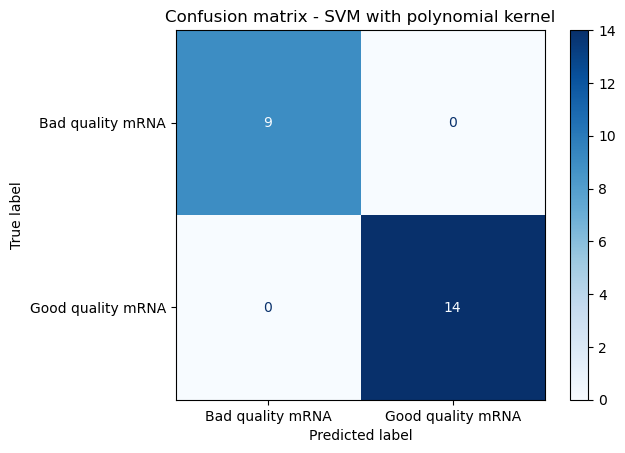

In [21]:
# Confusion matrix using test data
print("🔹Confusion matrix:")
ConfusionMatrixDisplay.from_predictions(
    y_test,  # Actual values
    y_test_pred_poly,  # Predicted values
    display_labels=["Bad quality mRNA", "Good quality mRNA"],  
    cmap='Blues'  # Color map
)
plt.title('Confusion matrix - SVM with polynomial kernel')
plt.show()

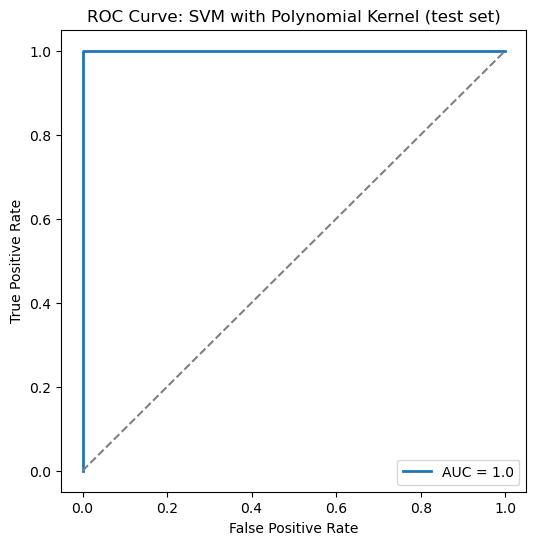

In [22]:
# Compute and plot ROC curve and AUC for polynomial model (test set)
y_test_scores_poly = best_svm_poly.decision_function(X_test_pca2)
fpr_poly, tpr_poly, _ = roc_curve(y_test, y_test_scores_poly)
roc_auc_poly = auc(fpr_poly, tpr_poly)

plt.figure(figsize=(6, 6))
plt.plot(fpr_poly, tpr_poly, lw=2, label=f'AUC = {roc_auc_poly:.1f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SVM with Polynomial Kernel (test set)')
plt.legend(loc='lower right')
plt.show()

In [23]:
n_per_class = best_svm_poly.n_support_        
total_sv   = n_per_class.sum() 
ratio = total_sv / len(X_train_pca2) 

In [24]:
text = f"""
### SVM model characteristics (Polynomial kernel)

- **Kernel:** `poly` (degree={best_svm_poly.degree}, coef0={best_svm_poly.coef0})  
- **Support vectors (per class):** {n_per_class.tolist()}  
- **Total support vectors:** {total_sv} ({ratio:.1%} of training data)  
- **AUC (test set):** {roc_auc_poly:.2f}  
"""

display(Markdown(text))


### SVM model characteristics (Polynomial kernel)

- **Kernel:** `poly` (degree=2, coef0=1)  
- **Support vectors (per class):** [13, 12]  
- **Total support vectors:** 25 (11.4% of training data)  
- **AUC (test set):** 1.00  


----

#### Task 9: Prediction results using both models

Predictions are calculated for both models.

In [25]:

probs_rbf  = np.round(best_svm_rbf.predict_proba(X_test_pca2)[:, 1], 2)
probs_poly = np.round(best_svm_poly.predict_proba(X_test_pca2)[:, 1], 2)

y_true = test_df["groups"] 

results_df = pd.DataFrame({
    "True_Label":       y_true,
    "Pred_RBF":         y_test_pred_rbf,
    "Prob_RBF_Class1":  probs_rbf,
    "Pred_Poly":        y_test_pred_poly,
    "Prob_Poly_Class1": probs_poly
}, index=test_df.index)

results_df.to_excel(NB_OUTPUT/"svm_test_predictions.xlsx", index=True)

print("✅ Predictions (with probabilities) saved to 'svm_test_predictions.xlsx'")

C:\Users\UserPhD\AppData\Local\Temp\ipykernel_18280\4157158354.py:14: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  results_df.to_excel(NB_OUTPUT/"svm_test_predictions.xlsx", index=True)


✅ Predictions (with probabilities) saved to 'svm_test_predictions.xlsx'


----

#### Task 10: Selection of the final SVM model

In [26]:

print("🎯 Best kernel choice: SVM (polynomial)")

🎯 Best kernel choice: SVM (polynomial)


The polynomial‐kernel SVM was the best choice, achieving top metrics and using fewer support vectors.

----

#### Task 11: Forming pipline from scaler, pca2, and best_svm_poly

In [27]:
pipeline = Pipeline([
    ('scaler', scaler),        
    ('pca',    pca2),           
    ('model',  best_svm_poly)   
])

# Saving pipeline into joblib, all parts have been already fitted
joblib.dump(pipeline, NB_OUTPUT /"final_pipeline_prob.joblib")

print("✅ The whole pipeline (scaler+PCA+SVM) has been saved as final_pipline_prob.joblib")

✅ The whole pipeline (scaler+PCA+SVM) has been saved as final_pipline_prob.joblib


----

#### Task 12: Visualizing the decision boundary for the polynomial SVM using the two principal components 

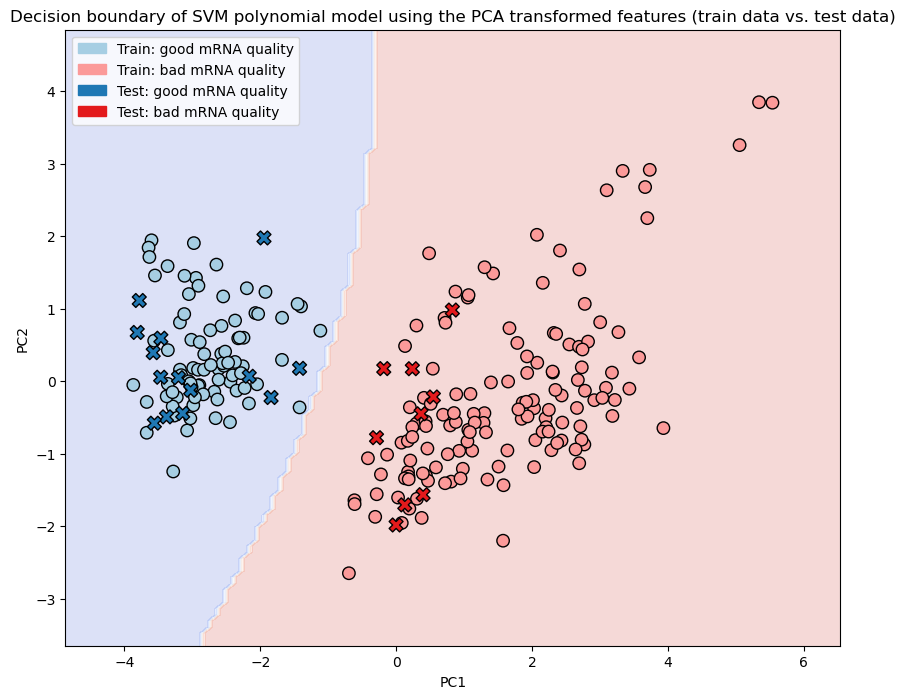

In [28]:
# Grid of points in PCA space
x_min, x_max = X_train_pca2[:, 0].min() - 1, X_train_pca2[:, 0].max() + 1
y_min, y_max = X_train_pca2[:, 1].min() - 1, X_train_pca2[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Grid point predictions (polynomial model)
Z = best_svm_poly.predict(grid_points)
Z = Z.reshape(xx.shape)

# Decision boundary plot in PCA space
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm_r)

# Color palettes for scatter plots
cmap_train = mcolors.ListedColormap(['#fb9a99', '#a6cee3'])  # Light colors for train data
cmap_test = mcolors.ListedColormap(['#e31a1c', '#1f78b4'])  # Dark colors for test data

# Training data scatter plot
scatter_train = plt.scatter(X_train_pca2[:, 0], X_train_pca2[:, 1],
                            c=y_train, cmap=cmap_train, edgecolors='k', s=80, label='Train')

# Testing data scatter plot
scatter_test = plt.scatter(X_test_pca2[:, 0], X_test_pca2[:, 1],
                           c=y_test, cmap=cmap_test, edgecolors='k', s=100, marker="X", label='Test')

# Legend patches
patch0_train = mpatches.Patch(color='#a6cee3', label='Train: good mRNA quality')
patch1_train = mpatches.Patch(color='#fb9a99', label='Train: bad mRNA quality')
patch0_test = mpatches.Patch(color='#1f78b4', label='Test: good mRNA quality')
patch1_test = mpatches.Patch(color='#e31a1c', label='Test: bad mRNA quality')

plt.legend(handles=[patch0_train, patch1_train, patch0_test, patch1_test], loc='upper left')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Decision boundary of SVM polynomial model using the PCA transformed features (train data vs. test data)')
plt.show()


----

#### Task 13: Summarizing training and testing data

- Training and test data collected on different days were imported. 
- Data were preprocessed, scaled with StandardScaler, and transformed via PCA (2 PCs). 
- SVMs with RBF and polynomial kernels were trained and evaluated. 
- The polynomial-kernel SVM was selected as the final model. 
- Test-data predictions were exported as a CSV file.
- The pipeline was saved as `final_pipeline_prob.joblib`. 
- The decision boundary at threshold = 0 was visualized for training and test data. 

----
----

Go to the file SVM_model optimalization.jpynb